In [ ]:
!pip install Historic-Crypto

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from Historic_Crypto import HistoricalData

In [ ]:
btc_historicals = HistoricalData('BTC-USD',60,'2016-1-1-00-00', '2022-1-20-00-00').retrieve_data()

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2016-01-01T00:00:00
Provisional End: 2016-01-01T05:00:00
Data for chunk 1 of 10613 extracted
Provisional Start: 2016-01-01T05:00:00
Provisional End: 2016-01-01T10:00:00
Data for chunk 2 of 10613 extracted
Provisional Start: 2016-01-01T10:00:00
Provisional End: 2016-01-01T15:00:00
Data for chunk 3 of 10613 extracted
Provisional Start: 2016-01-01T15:00:00
Provisional End: 2016-01-01T20:00:00
Data for chunk 4 of 10613 extracted
Provisional Start: 2016-01-01T20:00:00
Provisional End: 2016-01-02T01:00:00
Data for chunk 5 of 10613 extracted
Provisional Start: 2016-01-02T01:00:00
Provisional End: 2016-01-02T06:00:00
Data for chunk 6 of 10613 extracted
Provisional Start: 2016-01-02T06:00:00
Provisional End: 2016-01-02T11:00:00
Data for

KeyboardInterrupt: ignored

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paulrohan2020/bitcoin-historic-prices-from-oct2015-to-oct2021

 98% 50.0M/51.0M [00:00<00:00, 51.2MB/s]
100% 51.0M/51.0M [00:00<00:00, 69.8MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/bitcoin-historic-prices-from-oct2015-to-oct2021.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
root_path = '/content/btc_ohlc_Oct_2015_to_Oct_2021.csv'

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [ ]:
btc_input_df = pd.read_csv(root_path)
btc_input_df.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [ ]:
btc_input_df.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [ ]:
btc_input_df.shape

(3113276, 6)

In [ ]:
btc_input_df.describe()

,low,high,open,close,volume
count,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06,3.113276e+06
mean,1.152825e+04,1.154230e+04,1.153537e+04,1.153541e+04,9.689568e+00
std,1.490292e+04,1.492446e+04,1.491374e+04,1.491379e+04,2.239875e+01
min,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08
25%,1.849558e+03,1.850000e+03,1.849925e+03,1.849980e+03,1.331197e+00
50%,7.099990e+03,7.105000e+03,7.102045e+03,7.102060e+03,3.707298e+00
75%,1.067558e+04,1.068550e+04,1.068027e+04,1.068040e+04,9.761575e+00
max,6.690000e+04,6.699900e+04,6.694122e+04,6.694122e+04,1.549613e+03


In [ ]:
btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 142.5+ MB


In [ ]:
btc_input_df_datetype = btc_input_df.astype({'time': 'datetime64'})

In [ ]:
btc_input_df_datetype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 142.5 MB


In [ ]:
print('Null Values:',btc_input_df_datetype.isnull().values.sum())
print('If any NA values:', btc_input_df_datetype.isnull().values.any())

Null Values: 0
If any NA values: False


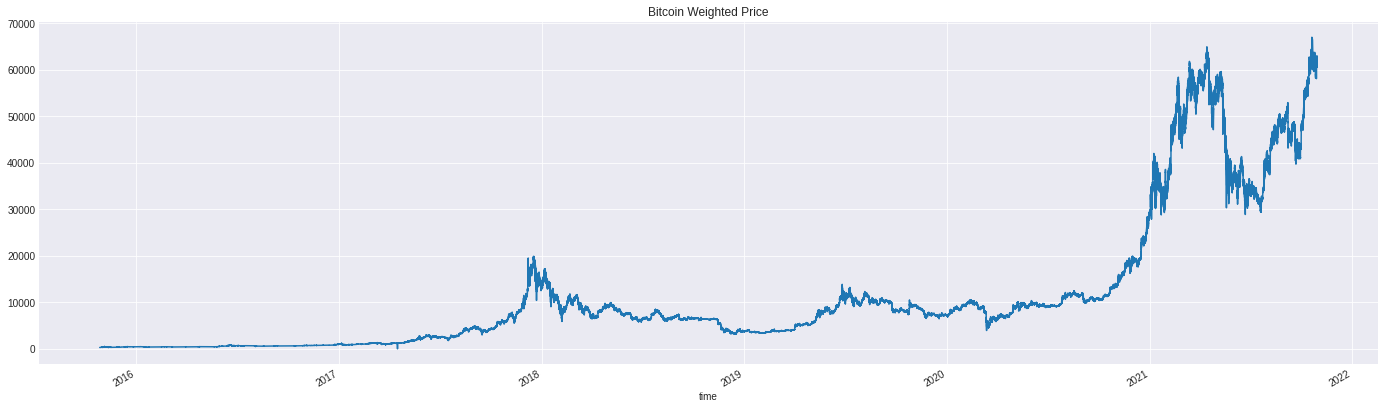

In [ ]:
btc_input_df_datetype.set_index("time").close.plot(figsize=(24,7), title="Bitcoin Weighted Price")

# **Lag Plot**

No handles with labels found to put in legend.


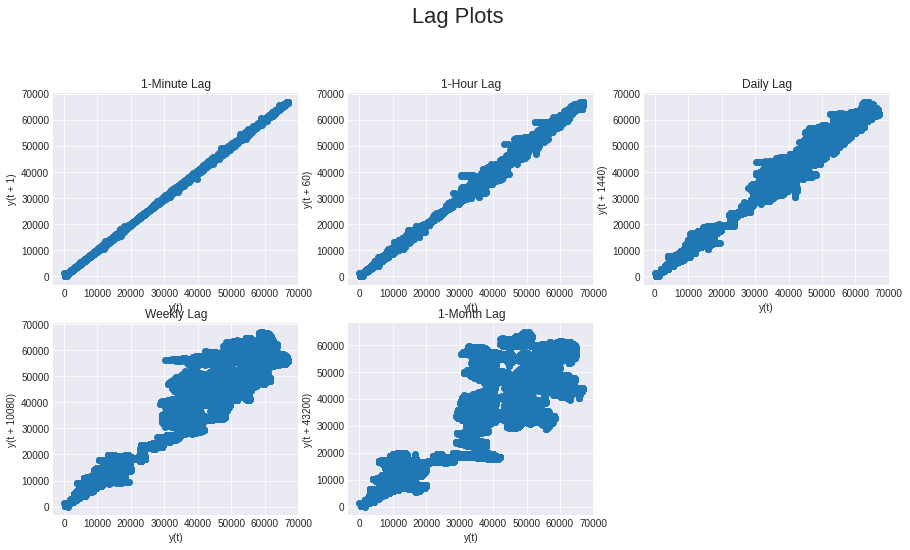

In [ ]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(btc_input_df_datetype['close'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.legend()
plt.show()

In [ ]:
btc_input_df_datetype['date'] = pd.to_datetime(btc_input_df_datetype['time'],unit='s').dt.date

display(btc_input_df_datetype.head())

group = btc_input_df_datetype.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,2021-10-30


In [ ]:
btc_closing_price_groupby_date.head()

date
2015-10-27    292.887484
2015-10-28    301.991834
2015-10-29    310.537530
2015-10-30    326.665808
2015-10-31    323.877132
Name: close, dtype: float64

In [ ]:
print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

Length of btc_closing_price_groupby_date : 2196


In [ ]:
prediction_days = 60
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [ ]:
df_test.shape

(60, 1)

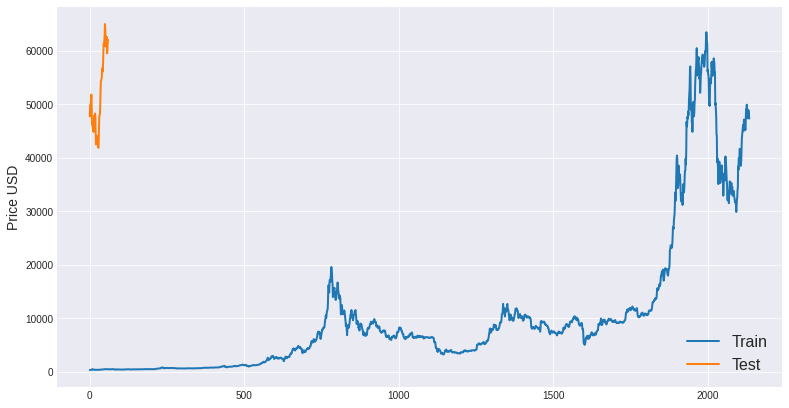

In [ ]:
chosen_col = 'Close'
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [ ]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)
scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [ ]:
def dataset_generator_lstm(dataset, look_back=5):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2131, 5)
trainY:  (2131,)
testX:  (55, 5)
testY (55,)


In [ ]:
print("trainX: ", trainX)
print("---")
print("trainY: ", trainY)

trainX:  [[0.00000000e+00 1.44159882e-04 2.79473948e-04 5.34851927e-04
  4.90695552e-04]
 [1.44159882e-04 2.79473948e-04 5.34851927e-04 4.90695552e-04
  4.21819458e-04]
 [2.79473948e-04 5.34851927e-04 4.90695552e-04 4.21819458e-04
  7.33745838e-04]
 ...
 [7.69797191e-01 7.59576884e-01 7.45106076e-01 7.51304260e-01
  7.69632673e-01]
 [7.59576884e-01 7.45106076e-01 7.51304260e-01 7.69632673e-01
  7.65970936e-01]
 [7.45106076e-01 7.51304260e-01 7.69632673e-01 7.65970936e-01
  7.56740572e-01]]
---
trainY:  [4.21819458e-04 7.33745838e-04 1.48661180e-03 ... 7.65970936e-01
 7.56740572e-01 7.44388678e-01]


In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))
print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (2131, 5, 1)
Shape of testX:  (55, 5, 1)


In [ ]:
print("trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features) ", trainX.shape[1])
print("trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features) ", trainX.shape[2])

trainX.shape[1] - i.e. timesteps in input_shape = (timesteps, n_features)  5
trainX.shape[2] - i.e. n_features in input_shape = (timesteps, n_features)  1


In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 256, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences = True,input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 64, activation = 'relu',input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 5, 256)            264192    
                                                                 
 dropout_28 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_41 (LSTM)              (None, 5, 128)            197120    
                                                                 
 dropout_29 (Dropout)        (None, 5, 128)            0         
                                                                 
 lstm_42 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)               

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)


Epoch 1/600
67/67 [==============================] - ETA: 0s - loss: 0.0154
Epoch 00001: val_loss improved from inf to 0.09644, saving model to my_best_model.hdf5
67/67 [==============================] - 13s 63ms/step - loss: 0.0154 - val_loss: 0.0964
Epoch 2/600
67/67 [==============================] - ETA: 0s - loss: 0.0465
Epoch 00002: val_loss improved from 0.09644 to 0.04437, saving model to my_best_model.hdf5
67/67 [==============================] - 4s 55ms/step - loss: 0.0465 - val_loss: 0.0444
Epoch 3/600
67/67 [==============================] - ETA: 0s - loss: 0.0205
Epoch 00003: val_loss did not improve from 0.04437
67/67 [==============================] - 4s 55ms/step - loss: 0.0205 - val_loss: 0.0447
Epoch 4/600
67/67 [==============================] - ETA: 0s - loss: 0.0063
Epoch 00004: val_loss improved from 0.04437 to 0.02652, saving model to my_best_model.hdf5
67/67 [==============================] - 5s 68ms/step - loss: 0.0063 - val_loss: 0.0265
Epoch 5/600
67/67 [====

In [ ]:
from tensorflow.keras.models import load_model
model_from_saved_checkpoint = load_model(checkpoint_path)

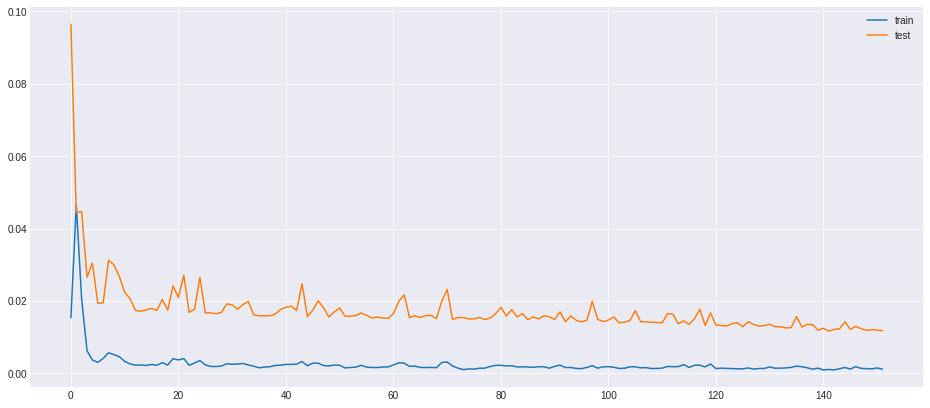

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

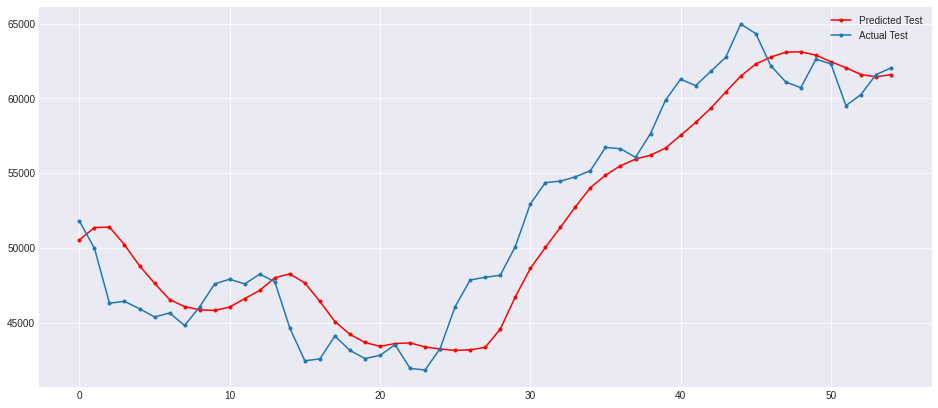

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

In [ ]:
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(-1, 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

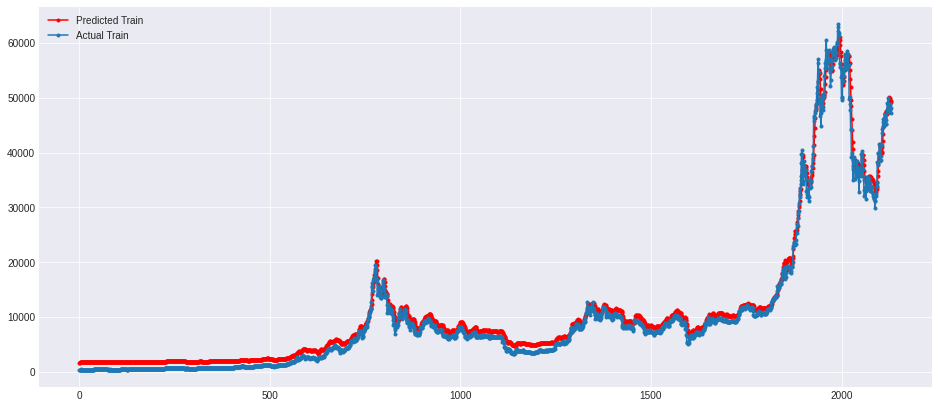

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.legend()
plt.show()

In [ ]:
btc_historicals = HistoricalData('BTC-USD',60,'2021-12-1-00-00', '2022-1-20-00-00').retrieve_data()

Checking input parameters are in the correct format.
Formatting Dates.
Checking if user supplied is available on the CoinBase Pro API.
Connected to the CoinBase Pro API.
Ticker 'BTC-USD' found at the CoinBase Pro API, continuing to extraction.
Provisional Start: 2021-12-01T00:00:00
Provisional End: 2021-12-01T05:00:00
Data for chunk 1 of 241 extracted
Provisional Start: 2021-12-01T05:00:00
Provisional End: 2021-12-01T10:00:00
Data for chunk 2 of 241 extracted
Provisional Start: 2021-12-01T10:00:00
Provisional End: 2021-12-01T15:00:00
Data for chunk 3 of 241 extracted
Provisional Start: 2021-12-01T15:00:00
Provisional End: 2021-12-01T20:00:00
Data for chunk 4 of 241 extracted
Provisional Start: 2021-12-01T20:00:00
Provisional End: 2021-12-02T01:00:00
Data for chunk 5 of 241 extracted
Provisional Start: 2021-12-02T01:00:00
Provisional End: 2021-12-02T06:00:00
Data for chunk 6 of 241 extracted
Provisional Start: 2021-12-02T06:00:00
Provisional End: 2021-12-02T11:00:00
Data for chunk 7 of 

In [ ]:
btc_historicals.head()

,low,high,open,close,volume
time,,,,,
2021-12-01 00:01:00,56771.72,56913.29,56874.03,56794.48,10.531591
2021-12-01 00:02:00,56712.99,56807.80,56794.92,56716.48,37.662240
2021-12-01 00:03:00,56705.06,56850.45,56719.72,56805.31,30.519310
2021-12-01 00:04:00,56787.47,56910.49,56798.99,56849.94,14.292182
2021-12-01 00:05:00,56812.65,57020.80,56854.28,57020.77,30.031048


In [ ]:
btc_historicals.reset_index(inplace=True)

In [ ]:
btc_historicals = btc_historicals.astype({'time': 'datetime64'})

In [ ]:
btc_historicals.head()

,index,time,low,high,open,close,volume
0,0,2021-12-01 00:01:00,56771.72,56913.29,56874.03,56794.48,10.531591
1,1,2021-12-01 00:02:00,56712.99,56807.80,56794.92,56716.48,37.662240
2,2,2021-12-01 00:03:00,56705.06,56850.45,56719.72,56805.31,30.519310
3,3,2021-12-01 00:04:00,56787.47,56910.49,56798.99,56849.94,14.292182
4,4,2021-12-01 00:05:00,56812.65,57020.80,56854.28,57020.77,30.031048


In [ ]:
btc_historicals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   index   72000 non-null  int64         
 1   time    72000 non-null  datetime64[ns]
 2   low     72000 non-null  float64       
 3   high    72000 non-null  float64       
 4   open    72000 non-null  float64       
 5   close   72000 non-null  float64       
 6   volume  72000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.8 MB


In [ ]:
btc_historicals = btc_historicals.drop(['index'],axis=1)

In [ ]:
btc_historicals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    72000 non-null  datetime64[ns]
 1   low     72000 non-null  float64       
 2   high    72000 non-null  float64       
 3   open    72000 non-null  float64       
 4   close   72000 non-null  float64       
 5   volume  72000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 3.3 MB


In [ ]:
print('Null Values:',btc_historicals.isnull().values.sum())
print('If any NA values:', btc_historicals.isnull().values.any())

Null Values: 0
If any NA values: False


In [ ]:
btc_historicals['date'] = pd.to_datetime(btc_historicals['time'],unit='s').dt.date
display(btc_historicals.head())
group = btc_historicals.groupby('date')
btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-12-01 00:01:00,56771.72,56913.29,56874.03,56794.48,10.531591,2021-12-01
1,2021-12-01 00:02:00,56712.99,56807.80,56794.92,56716.48,37.662240,2021-12-01
2,2021-12-01 00:03:00,56705.06,56850.45,56719.72,56805.31,30.519310,2021-12-01
3,2021-12-01 00:04:00,56787.47,56910.49,56798.99,56849.94,14.292182,2021-12-01
4,2021-12-01 00:05:00,56812.65,57020.80,56854.28,57020.77,30.031048,2021-12-01


In [ ]:
display(btc_closing_price_groupby_date.head(10))
print("Length of btc_closing_price_groupby_date :", len(btc_closing_price_groupby_date))

date
2021-12-01    57400.983231
2021-12-02    56703.883639
2021-12-03    55872.084687
2021-12-04    49068.275188
2021-12-05    49155.782104
2021-12-06    48856.771910
2021-12-07    51023.399903
2021-12-08    50320.988132
2021-12-09    49076.378667
2021-12-10    48253.620667
Name: close, dtype: float64

Length of btc_closing_price_groupby_date : 51


In [ ]:
scaler_t = MinMaxScaler(feature_range=(0, 1))
scaled_t = scaler_t.fit_transform(btc_closing_price_groupby_date.values.reshape(-1,1))

In [ ]:
print(scaled_t.shape)

(51, 1)


In [ ]:
tx,ty=dataset_generator_lstm(scaled_t)

In [ ]:
tx = np.reshape(tx, (tx.shape[0], tx.shape[1], 1))

In [ ]:
predicted_btc_price = model_from_saved_checkpoint.predict(tx)
predicted_btc_price = scaler_t.inverse_transform(predicted_btc_price.reshape(-1, 1))
test_actual = scaler_t.inverse_transform(ty.reshape(-1, 1))

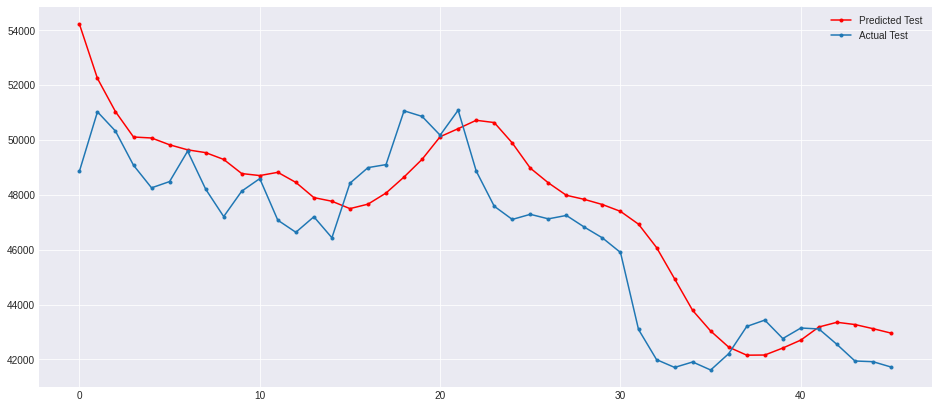

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(predicted_btc_price, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()